In [165]:
from dotenv import load_dotenv
load_dotenv()

MAX_TOKENS = 1000

In [187]:
from openai import OpenAI
import groq
from anthropic import Anthropic
from pydantic import BaseModel
import instructor

class StatementInfo(BaseModel):
    is_true: int
    # reason: str

def get_prompt(table_data: str, statement: str, caption: str):
    prompt = [
            {
                "role": "system",
                "content": f"You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of {caption}: \n\n{table_data}. Response should only contain a single character 1 for True or 0 for False.",
            },
            {
                "role": "user",
                "content": f"{statement}"
            }
        ]
    return prompt
    
def get_openai_response(prompt: list) -> str:
    """Get response from OpenAI's model"""
    client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
    # response = client.chat.completions.create(
    response = client.beta.chat.completions.parse(
        model=os.getenv('OPENAI_MODEL'),  # Use from settings
        messages=prompt,
        max_tokens=MAX_TOKENS,  # Use from settings
        response_format=StatementInfo
    )
    result = response.choices[0].message.parsed #.choices[0].message.content
    return result.is_true

def get_groq_llama_response(prompt: list) -> str:
    """Get response from Groq's Llama model"""
    client = instructor.from_groq(groq.Groq(api_key=os.getenv('GROQ_API_KEY')), mode=instructor.Mode.JSON)
    # client = groq.Groq(api_key=os.getenv('GROQ_API_KEY'))
    response = client.chat.completions.create(
        model=os.getenv('GROQ_LLAMA_MODEL'),
        messages=prompt,
        max_tokens=MAX_TOKENS,
        response_model=StatementInfo
    )
    return response.is_true
    # return response.choices[0].message.content

def get_groq_mixtral_response(prompt: list) -> str:
    """Get response from Groq's Mixtral model"""
    try: 
        client = instructor.from_groq(groq.Groq(api_key=os.getenv('GROQ_API_KEY')), mode=instructor.Mode.JSON)
        # client = groq.Groq(api_key=os.getenv('GROQ_API_KEY'))
        response = client.chat.completions.create(
            model=os.getenv('GROQ_MIXTRAL_MODEL'),
            messages=prompt,
            max_tokens=MAX_TOKENS,
            response_model=StatementInfo
        )
        # print(response)
        return response.is_true
        # return response.choices[0].message.content
    except:
        return None

def get_claude_response(prompt: list) -> str:
    try:
        """Get response from Anthropic's Claude"""
        # client = Anthropic(api_key=os.getenv('CLAUDE_API_KEY'))
        client = instructor.from_anthropic(Anthropic(api_key=os.getenv('CLAUDE_API_KEY')))
        response = client.messages.create(
            model=os.getenv('CLAUDE_MODEL'),  # We'll add this to settings
            system=prompt[0]['content'],
            messages=[prompt[1]],
            max_tokens=MAX_TOKENS+1,
            response_model=StatementInfo
        )
        return response.is_true #response.content[0].text
    except:
        return None

In [167]:
# load test file 
import json 
file_path = "./test_examples.json"
with open(file_path, 'r') as file:
    test_examples = json.load(file)

target_list = list(test_examples.keys())[:10]


In [168]:
import pandas as pd

data = pd.read_csv(f'./all_csv/{target_list[2]}', sep='#')
data

,no overall,no for series,title,directed by,written by,original air date,uk viewers (million)
0,14,1,the curse of cornelius sigan,david moore,julian jones,19 september 2009,5.77
1,15,2,the once and future queen,jeremy webb,howard overman,26 september 2009,5.94
2,16,3,the nightmare begins,jeremy webb,ben vanstone,3 october 2009,6.09
3,17,4,lancelot and guinevere,david moore,howard overman,10 october 2009,5.69
4,18,5,beauty and the beast (part 1),david moore,jake michie,24 october 2009,5.53
5,19,6,beauty and the beast (part 2),metin huseyin,ben vanstone,31 october 2009,6.14
6,20,7,the witchfinder,jeremy webb,jake michie,7 november 2009,5.62
7,21,8,the sins of the father,metin huseyin,howard overman,14 november 2009,6.16
8,22,9,the lady of the lake,metin huseyin,julian jones,21 november 2009,6.30
9,23,10,sweet dreams,alice troughton,lucy watkins,28 november 2009,6.02


In [31]:
questions = test_examples[target_list[0]]

In [169]:
eval_data = pd.DataFrame(columns=['key', 'prompt', 'expected_result', 'openai_result', 'llama_result', 'mixtral_result', 'claude_result'])
for t_index, table_Key in enumerate(target_list):
    table_data = pd.read_csv(f'./all_csv/{table_Key}', sep='#')
    questions = test_examples[table_Key]
    for q_index, q in enumerate(questions[0]):
        expected_result = questions[1][q_index]
        prompt = get_prompt(table_data.to_string(), q, questions[2])
        eval_data.loc[len(eval_data)] = {'key': table_Key, 'prompt': prompt, 'expected_result': expected_result}


In [170]:
eval_data

,key,prompt,expected_result,openai_result,llama_result,mixtral_result,claude_result
0,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
1,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
2,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
3,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
4,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
94,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN
95,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN
96,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN
97,2-17340355-10.html.csv,"[{'role': 'system', 'content': 'You are a help...",0,NaN,NaN,NaN,NaN


In [172]:
eval_data.iloc[0, 1]

[{'role': 'system',
  'content': 'You are a helpful assistant who can understand structured table data. You need to help identify if a statement is True/False based on the data of tony lema: \n\n              tournament  wins  top - 5  top - 10  top - 25  events  cuts made\n0     masters tournament     0        1         2         4       4          4\n1                us open     0        2         3         4       6          5\n2  the open championship     1        2         2         2       3          3\n3       pga championship     0        0         1         2       5          4\n4                 totals     1        5         8        12      18         16. Response should only contain a single character 1 for True or 0 for False.'},
 {'role': 'user',
  'content': 'tony lema be in the top 5 for the master tournament , the us open , and the open championship'}]

In [188]:
eval_data['openai_result'] = eval_data['prompt'].apply(lambda x : int(get_openai_response(x)))
eval_data['llama_result'] = eval_data['prompt'].apply(get_groq_llama_response)
eval_data['mixtral_result'] = eval_data['prompt'].apply(get_groq_mixtral_response)
eval_data['claude_result'] = eval_data['prompt'].apply(get_claude_response)

In [195]:
eval_data.head()

,key,prompt,expected_result,openai_result,llama_result,mixtral_result,claude_result
0,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,0.0,1
1,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1
2,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,1.0,1
3,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,1,0.0,1
4,2-1570274-4.html.csv,"[{'role': 'system', 'content': 'You are a help...",1,1,0,1.0,1


In [190]:
eval_data['claude_result'] = eval_data['prompt'].apply(get_claude_response)


Accuracy OpenAI: 0.88, Llama: 0.76, Mixtral: 0.58, Claude: 0.84


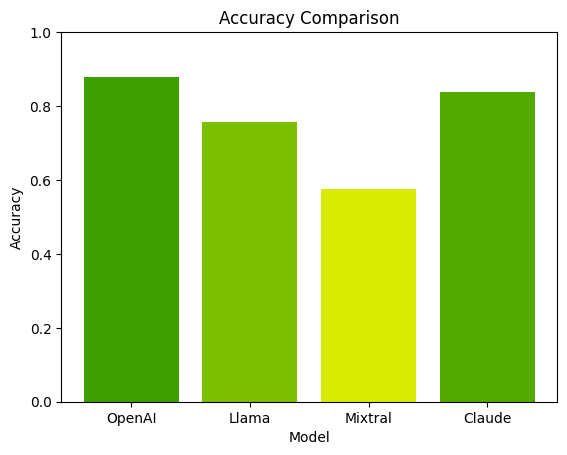

In [191]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime


# eval_data

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'results_{timestamp}.json'
eval_data.to_json(f'./table_fact_check/{filename}', orient='records')

# eval_data['openai_result'] = eval_data['openai_result'].apply(lambda x : int(x))


df = eval_data
accuracy_openai = (df['expected_result'] == df['openai_result']).mean()
accuracy_llama = (df['expected_result'] == df['llama_result']).mean()
accuracy_mixtral = (df['expected_result'] == df['mixtral_result']).mean()
accuracy_claude = (df['expected_result'] == df['claude_result']).mean()
print(f'Accuracy OpenAI: {accuracy_openai:.2f}, Llama: {accuracy_llama:.2f}, Mixtral: {accuracy_mixtral:.2f}, Claude: {accuracy_claude:.2f}')


# Define a custom colormap
cmap = LinearSegmentedColormap.from_list("custom", ["red", "yellow", "green"])
methods = ['OpenAI', 'Llama', 'Mixtral', 'Claude']
accuracy = [accuracy_openai, accuracy_llama, accuracy_mixtral, accuracy_claude]
# Normalize the accuracy values to be between 0 and 1
norm = plt.Normalize(vmin=0, vmax=1)
# Create a bar chart with colored bars
for i, (method, acc) in enumerate(zip(methods, accuracy)):
    plt.bar(i, acc, color=cmap(norm(acc)))
# Set the title and labels
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(range(len(methods)), methods)
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
# Show the plot
plt.show()

Accuracy OpenAI: 0.90, Llama: 0.70, Mixtral: 0.50, Claude: 0.90


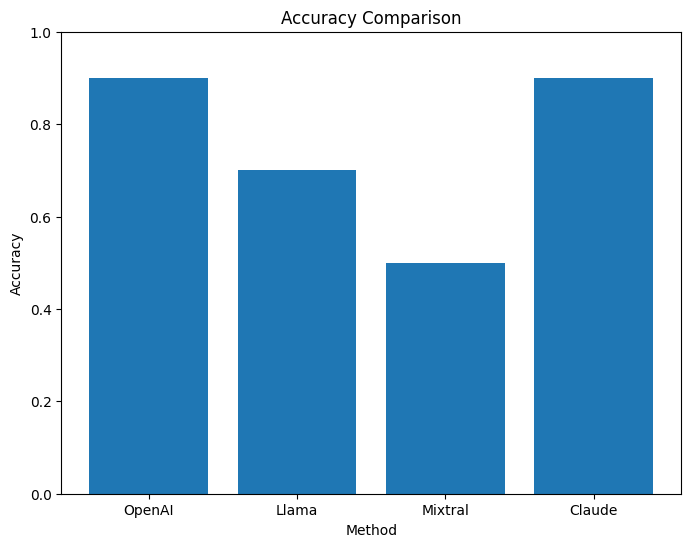

In [174]:
import matplotlib.pyplot as plt

# df = eval_data
accuracy_openai = (df['expected_result'] == df['openai_result']).mean()
accuracy_llama = (df['expected_result'] == df['llama_result']).mean()
accuracy_mixtral = (df['expected_result'] == df['mixtral_result']).mean()
accuracy_claude = (df['expected_result'] == df['claude_result']).mean()

print(f'Accuracy OpenAI: {accuracy_openai:.2f}, Llama: {accuracy_llama:.2f}, Mixtral: {accuracy_mixtral:.2f}, Claude: {accuracy_claude:.2f}')
# Plot the accuracy values
methods = ['OpenAI', 'Llama', 'Mixtral', 'Claude']
accuracy_values = [accuracy_openai, accuracy_llama, accuracy_mixtral, accuracy_claude]
plt.figure(figsize=(8,6))
plt.bar(methods, accuracy_values)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
plt.show()

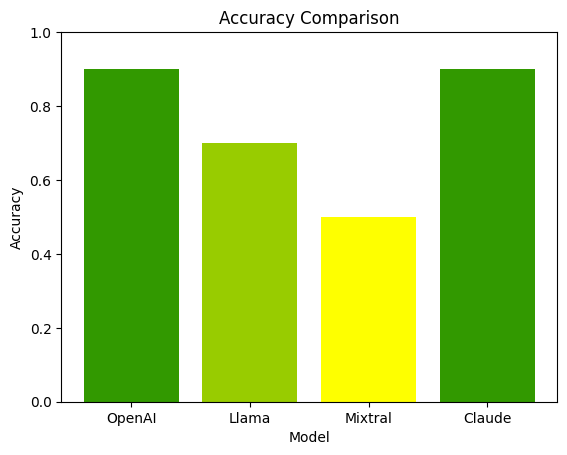

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap
cmap = LinearSegmentedColormap.from_list("custom", ["red", "yellow", "green"])
# Generate some random data
# methods = ['Method1', 'Method2', 'Method3']
# accuracy = [0.2, 0.9, 0.5]
print(f'Accuracy OpenAI: {accuracy_openai:.2f}, Llama: {accuracy_llama:.2f}, Mixtral: {accuracy_mixtral:.2f}, Claude: {accuracy_claude:.2f}')
methods = ['OpenAI', 'Llama', 'Mixtral', 'Claude']
accuracy = [accuracy_openai, accuracy_llama, accuracy_mixtral, accuracy_claude]
# Normalize the accuracy values to be between 0 and 1
norm = plt.Normalize(vmin=0, vmax=1)
# Create a bar chart with colored bars
for i, (method, acc) in enumerate(zip(methods, accuracy)):
    plt.bar(i, acc, color=cmap(norm(acc)))
# Set the title and labels
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(range(len(methods)), methods)
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
# Show the plot
plt.show()